# QLSD++ 

In [ ]:
"""
Written by Zachary Jones
"""
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy

# random seed set for reproducability, decreases performance
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set-up and Data preparation

## Prior and Preconditioner classes used in gradient calculation

In [ ]:
class Prior():
  def __init__(self, model = "gaussian", **kwargs):
    '''
    Indedpendent of the form, each instantation of the 'Prior' class keeps
    track of the model used, (gaussian etc.) and checks for parameters.
    Each particular instantation of a model must include a 'gradLog' function
    which returns the distribution specific gradient of the NEGATIVE log
    liklihood.

    This is used as part of the gradient calculation for bayesian learning
    '''
    self.model = model
    self.params = kwargs.get("params", None)

    if self.params == None:
      raise ValueError("Something has gone horribly wrong: invalid parameters")

  def __name__(self):
    return self.__class__.__name__
    
  def to(self,device):
    self.device = device


      
class Gaussian(Prior):
  def __init__(self, mean = 0.0, sig = 0.1):
    super(Gaussian, self).__init__("gaussian", params = {"mean": mean, "sig": sig})
    self.mean = torch.tensor([mean])
    self.sig = torch.tensor([sig])

  def prior(self, theta):

    logPrior = torch.norm(theta - self.mean)
    logPrior=-logPrior*logPrior/(2*self.sig**2)\
    -.5*torch.log(2*torch.pi*self.sig**2)*len(theta)

    gradLogPrior = (theta - self.mean)/self.sig**2

    self.logPrior = logPrior
    self.gradLogPrior = gradLogPrior

    return(logPrior, gradLogPrior)


  # optimize the negative log liklihood later in the model, so this is the grad
  # of the negative log prior
  def grad_log(self, theta):
    return (theta - self.mean)/self.sig**2

  def to(self,device):
    self.device = device
    self.mean = self.mean.to(device)
    self.sig = self.sig.to(device)


# Assuming normally distributed weights this is the conjugate prior.
class InverseGamma(Prior):
  def __init__(self, alpha = 0.01, beta = 0.01):
    super(InverseGamma, self).__init__("inv_gamma", params = {"alpha" : alpha,
                                                              "beta": beta})
    self.alpha = alpha
    self.beta = beta

  def __name__(self):
    return "InverseGamma"

  def prior(self, theta):
    logPrior = self.alpha * torch.log(self.beta) - (self.alpha + 1) \
    * torch.log(theta) - self.beta/theta - torch.lgamma(self.alpha)

    gradLogPrior = -(self.alpha + 1)/theta + self.beta/theta**2
    return(logPrior, gradLogPrior)
    
  def grad_log(self, theta):
    gradLogPrior = -(self.alpha + 1)/theta + self.beta/theta**2
    return gradLogPrior

  def to(self,device):
    self.device = device
    self.alpha = torch.tensor([self.alpha]).to(device)
    self.beta = torch.tensor([self.beta]).to(device)

In [ ]:
from math import sqrt
from scipy.linalg import fractional_matrix_power

class Preconditioner():
  def __init__(self, d1, d2):
    '''
    As the preconditioner must operate on both weights and biases in the model
    according to their dimension, which are unknown before hand, they are set
    at instantation.  Using 'torch.Einsum('ij, i...', A, sample)', allows for
    both speed and flexibility in the form of the inner product (biases are kept
    by pytorch as 1d tensors so matmul operations cannot be used)

    Each 'Preconditioner' must have an 'Apply' and 'Sample' function, which are
    used at different stages of gradient calculation.
    
    Apply : return an (N_out x N_out matrix) with N_out beind the output
    dimension of the layer

    Sample: Return an N_out x N_out matrix which has been multiplied by a matrix
    of iid random normal samples with dimension (N_out x N_in) (the same as the
    weights)
    '''
    if d2:
      self.type = 'weight'
      self.input_size = d2

    else:
      self.input_size = 1
      self.type = "bias"

    self.output_size = d1
    self.C = torch.eye(d1)
    self.A = torch.eye(d1)


  def update(self, grad):
    pass

  def to(self, device):
    self.C = self.C.to(device)
    self.A = self.A.to(device)
    self.device = device
    return self

# Euclidean preconditioner for use in gradient step does not change the
# distribution of the weights.  
class Euclidean(Preconditioner):
  def __init__(self, d1, d2 = None):
    super(Euclidean, self).__init__(d1, d2)

  def apply(self):
    return self.C

  def sample(self):
    if self.type == 'weight':
      sample = torch.randn(self.output_size, self.input_size).to(self.device)
    else:
      sample = torch.randn(self.output_size).to(self.device)

    # use torch.einsum instead of distinguishing between bias and weight terms,
    # not particularly slow.
    return(torch.einsum("ij,j... -> i...",self.A, sample))


# RMSProp preconditioner corresponds to giving each weight a seperate learning
# rate
class RMSProp(Preconditioner):
  def __init__(self, d1, d2 = None, decay_rate = .5, regularizer = 1e-7):
    super(RMSProp, self).__init__(d1, d2)
    self.decay_rate = decay_rate
    self.regularizer = regularizer

  @torch.no_grad()
  def update(self,grad):
    if self.type == "weight":
      g_sq = torch.einsum("ij,ij->i",grad,grad).diag()

    else:
      g_sq = torch.mul(grad,grad)

    self.C.mul_(1.0 - self.decay_rate).add_(g_sq, alpha = self.decay_rate)


    local_time = 1./(self.decay_rate**2) + 1.0
    self.decay_rate = 1.0/sqrt(local_time)

  def apply(self):
    c = ((self.C.diag() + self.regularizer).pow(-0.5)).diag()
    return c

  def sample(self):
    if self.type == 'weight':
      sample = torch.randn(self.output_size, self.input_size).to(self.device)
    else:
      sample = torch.randn(self.output_size).to(self.device)

    c = ((self.C.diag() + self.regularizer).pow(-0.25)).diag()
    return(torch.einsum("ij,j... -> i...",c , sample))

  def to(self, device):
    self.A = self.A.to(device)
    self.C = self.C.to(device)
    self.device = device
    self.regularizer = torch.tensor([self.regularizer]).to(device)
    return(self)


# Adam preconditioner corresponds to giving each weight a seperate learning
# rate
class Adam(Preconditioner):
  def __init__(self, d1, d2 = None, decay_rate = .5, regularizer = 1e-7):
    super(Adam, self).__init__(d1, d2)
    self.decay_rate = decay_rate
    self.regularizer = regularizer

  @torch.no_grad()
  def update(self,grad):
    if self.type == "weight":
      g_sq = torch.einsum("ij,ij->i",grad,grad).diag()

    else:
      g_sq = torch.mul(grad,grad)

    g = g_sq.sqrt()

    self.C.mul_(1.0 - self.decay_rate).add_(g_sq, alpha = self.decay_rate)
    self.A.mul_(1.0 - .9/.99*self.decay_rate).add_(g, alpha = .9/.99*self.decay_rate)


    local_time = 1./(self.decay_rate**2) + 1.0
    self.decay_rate = 1.0/sqrt(local_time)

  def apply(self):
    c = (self.A.diag()*((self.C.diag() + self.regularizer).pow(-0.5))).diag()
    return c

  def sample(self):
    if self.type == 'weight':
      sample = torch.randn(self.output_size, self.input_size).to(self.device)
    else:
      sample = torch.randn(self.output_size).to(self.device)

    c = (self.A.diag().pow(.5)*((self.C.diag() + self.regularizer).pow(-0.25))).diag()
    return(torch.einsum("ij,j... -> i...",c , sample))

  def to(self, device):
    self.A = self.A.to(device)
    self.C = self.C.to(device)
    self.device = device
    self.regularizer = torch.tensor([self.regularizer]).to(device)
    return(self)


# inverting the fisher information matrix is extremely espensive, restrict to
# smaller models.  Fisher information gives the curvature around the gradient
# estimator and yields Amari's natural gradient
class Fisher(Preconditioner):
  def __init__(self, d1, d2 = None, decay_rate = .1, regularizer = 1e-7):
    super(Fisher, self).__init__(d1, d2)
    self.decay_rate = decay_rate
    self.regularizer = regularizer

  @torch.no_grad()
  def update(self, grad):
    self.C.mul_(1.0 - self.decay_rate)

    if self.type != 'weight':
      grad = grad.unsqueeze(-1)

    self.C.add_(torch.matmul(grad, grad.T),alpha = self.decay_rate)

    local_time = 1.0/self.decay_rate + 1.0
    self.decay_rate = 1.0/sqrt(local_time)

  def apply(self):
    return torch.linalg.inv(torch.add(self.C,
                                      torch.eye(self.output_size).to(self.device),
                                      alpha = self.regularizer))

  def sample(self):
    if self.type == "weight":
      sample = torch.randn(self.output_size, self.input_size).to(self.device)
    else:
      sample = torch.randn(self.output_size).to(self.device)
    
    pre = torch.add(self.C, torch.eye(self.output_size).to(device), \
                    alpha = self.regularizer)
    
    # find a better matrix square root algo this is slow and cumbersome
    return torch.linalg.solve(
        torch.from_numpy(
            fractional_matrix_power(
                pre.cpu(), 0.5)).to(torch.float).to(self.device), sample)

  def to(self, device):
    self.device = device
    self.A = self.A.to(device)
    self.C = self.C.to(device)
    return(self)

# The quasi diagonal cholesky decomposition of the inverse fisher information 
# agrees with the inverse fisher information matrix on the diagonals and the 
# first row.  Use this as an approximation of the fisher info for larger models.
class QDC(Preconditioner):
  def __init__(self, d1, d2 = None, decay_rate = .5, regularizer = 1e-6):
    super(QDC,self).__init__(d1,d2)
    self.decay_rate = decay_rate
    self.regularizer = regularizer

  @torch.no_grad()
  def update(self, grad):
    self.C.mul_(1.0 - self.decay_rate)


    '''
    if self.type == "weight":
      g_row = torch.matmul(grad[0,:], grad.T)
      g_diag = torch.einsum("ij,ji -> i", grad, grad.T).diag()

    else:
      grad_unsqueezed = torch.unsqueeze(grad,-1)
      g_row = torch.mul(grad[0], grad_unsqueezed.T)
      g_diag = torch.mul(grad, grad).diag()
    '''

    if self.type != 'weight':
      grad = grad.unsqueeze(-1)

    g = torch.matmul(grad, grad.T)
    g_diag = g.diag()
    g_row = g[0,:]

    g_factor = g_diag.diag()
    g_factor[0,:] = g_row

    self.C.add_(g_factor, alpha = self.decay_rate)

    self.A = torch.zeros_like(self.A)

    a00 = torch.add(self.C[0,0], self.regularizer).pow(-0.5)
    self.A[0,0] = a00

    if a00.isnan():
      print(a00)

    for i in range(1,len(self.A)):
      a00C0i = torch.mul(a00,self.C[0,i]).pow(2)


      if a00C0i.isnan():
        print(a00, self.C[0,i])
        raise ValueError('nan')

      Ciia00C0i = torch.add(self.C[i,i], a00C0i, alpha = -1.0)

      
      if Ciia00C0i.isnan():
        print(self.C[i,i], a00C0i)
        raise ValueError('nan')

      self.A[i,i] = torch.pow(Ciia00C0i + self.regularizer, -0.5)

      AiiC0i = self.A[i,i].mul(self.C[0,i])

      
      if AiiC0i.isnan():
        print(self.A[i,i], self.C[0,i])
        raise ValueError('nan')

      self.A[0,i] = torch.mul(-(a00.pow(2)), AiiC0i)

    local_time = 1.0/self.decay_rate + 1.0
    self.decay_rate = 1.0/sqrt(local_time)

  def apply(self):
    if self.A.isnan().any():
      print(self.A)
      raise ValueError('dicks')

    return self.A.matmul(self.A.T)

  def sample(self):
    if self.type == "weight":
      sample = torch.randn(self.output_size, self.input_size).to(self.device)
    else:
      sample = torch.randn(self.output_size).to(self.device)

    return(torch.einsum("ij,j... -> i...", self.A, sample))

  def to(self, device):
    self.device = device
    self.A = self.A.to(device)
    self.C = self.C.to(device)
    return(self)

## Dataset: MNIST

In [ ]:
MNIST = torchvision.datasets.MNIST(root = ".", 
                                   train = True,
                                   download = True)

output_dimension = len(MNIST.classes)
input_dimension = len(MNIST.data[0])**2
batch_size = 100

In [ ]:
MNIST.data[0].shape

torch.Size([28, 28])

In [ ]:
MNIST.targets[0]

tensor(5)

## Data Structure

A thoughtful datastructure simpliefies the minimization, since the whole gradient must be 

calculated periodically and individual gradient samples must be matched in a variance

reduction technique.

In [ ]:
class CycleSplitData(torch.utils.data.Dataset):
  def __init__(self, dataset, k, transform = None):
    '''
    The dataset given to each virtual submodel is kept in a list of k tuples
    corresponding to the local dataset each with a data tensor of dimension 
    (N_k, d), their corresponding labels, and the index of the data point.
    This allows for the index of points used to be passed to the model for
    individual gradient evaluations.

    Images are accessed as handle[i, j][0] with image j of partition i
    Their corresponding target as handle [i, j][1]
    The index as [i, j][2]
    '''

    N = len(dataset)

    splits = np.random.choice(k, N, replace = True)
    partition_sizes = [np.sum(splits == i) for i in range(k)]
    indices = [torch.arange(partition_sizes[i]) for i in range(k)]

    partition_sizes = [0] + partition_sizes
    partition_boundaries = np.cumsum(partition_sizes)


    if transform is None:
      split_data = [dataset.data[partition_boundaries[i]:partition_boundaries[i+1],:,:]\
                    for i in range(len(partition_boundaries)-1)]
    else:
      split_data = [dataset.data[partition_boundaries[i]:partition_boundaries[i+1],:,:]\
                    for i in range(len(partition_boundaries)-1)]   

    split_targets = [dataset.targets[partition_boundaries[i]:partition_boundaries[i+1]]\
                  for i in range(len(partition_boundaries)-1)]

    self.N = max(partition_sizes)

    self.k = k

    self.data = split_data

    self.targets = split_targets

    self.indices = indices

    self.partition_sizes = partition_sizes[1:]

    self.transform = transform

  def __getitem__(self, idx):

    if self.transform:
      data = self.transform(self.data[idx[0]][idx[1],:,:])

    else:
      data = self.data[idx[0]][idx[1],:,:].to(torch.float)

    return (data,
            self.targets[idx[0]][idx[1]],
            self.indices[idx[0]][idx[1]])

    
  def __len__(self):
    return self.N

  def shuffle(self):
    for i in range(self.k):
      n = len(self.indices[i])
      perm = np.random.choice(n,n, replace = False)

      self.data[i] = self.data[i][perm,:,:]
      self.targets[i] = self.targets[i][perm]
      self.indices[i] = torch.from_numpy(perm)

  def sample(self, N = None):
    if N == None:

      if self.transform:
        data =[self.transform(data) for data in self.data]
      else:
        data = [data.to(torch.float) for data in self.data]
        
      return (data,
              self.targets,
              self.indices)

    else:
      data = []
      targets = []
      indices = []

      for i in range(self.k):
        n = len(self.indices[i])
        perm = np.random.choice(n, N)

        if self.transform:
          data_i = self.transform(self.data[i][perm, :, :])
        else:
          data_i = self.data[i][perm, :, :].to(torch.float)
          
        data.append(data_i)
        targets.append(self.targets[i][perm])
        indices.append(self.indices[i][perm])

      return(data, targets, indices)


## Per-sample gradients: Use Opacus Library

In [ ]:
!pip install opacus
from opacus.grad_sample import GradSampleModule

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Gradient Compression

In [ ]:
def quantize(v, s):

  # Different operations required for different gradient dimensions (weights vs
  # biases)
  
  if len(v.shape) > 1:
    v_norm = v.norm(dim = 1)
    
    l = torch.einsum("ij, i-> ij", v.abs().mul(s), v_norm.pow(-1))
    deterministic_part = torch.einsum("ij,i-> ij", v.sign(), v_norm).div(s)

  else:
    v_norm = v.norm()

    l = v.abs().mul(s).div(v_norm)
    deterministic_part = v_norm.mul(v.sign()).div(s)

  random_part = l.floor().add(torch.rand_like(v).le(torch.add(l, l.floor(), alpha = -1)).mul(1.0))
  out = deterministic_part.mul(random_part)
  
  # If the gradient is zero in some dimensions it will result in NaNs due to the
  # normalization above. These points should be kept as Zeros.
  out[out.isnan()] = 0.
  
  return(out)

# Optimizer objects

In order to streamline training, the QLSD++ algorithm is split into two parts
an optimizer object meant to load onto local agents and a counterpart for the
central server.

TODO:
-Investigate this warning
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior. warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


## Local QLSD Optimizer

In [ ]:
from torch._C import parse_schema
import torch
from torch.optim.optimizer import Optimizer, required
import math

class QlsdPPLocal(Optimizer):
  '''
  Local model which does not modify parameters during a "step" phase, only
  modifying the gradients of the parameters to be aggregated later in a
  step of the central model.  Each distributed model will has its own associated
  optimizer which manages layerwise operations and gradient calculations.
  '''

  def __init__(self, params,
               prior = Gaussian(0,.1), 
               N = required,
               l = required,
               s = required):

    if not prior:
      raise ValueError("No prior specified")

    if N is not required and N < 0:
      raise ValueError("Need the size of the local dataset")

    if l is not required and (l < 0 or l % 1 != 0):
      raise ValueError("Control variable periodicity must be a nonnegative integer")

    if s is not required and (s < 0 or s % 1 != 0):
      raise ValueError('Quantization must be a nonnegative integer')

    defaults = dict(prior = prior,
                    N = N,
                    eta = [],
                    alpha = [],
                    Uzeta = [],
                    Uzeta_ij = [],
                    l = l,
                    s = s)
    
    super(QlsdPPLocal, self).__init__(params, defaults)

    for group in self.param_groups:
      # Memory term used in quantization to reduce error
      eta = []

      # memory term learning rate
      # alpha should be initialized as 1/(omega + 1) as in the paper
      # omega = min(min(d/s2, √d/s) with d the dimension of the gradient
      alpha = []

      # initialize all these values after p has been stored as a parameter
      with torch.no_grad():
        for p in group["params"]:
          eta.append(torch.zeros_like(p).to(p.device))
          d = p.shape[-1]
          alpha.append(1/(1 + min(d/(s**2), math.sqrt(d)/s)))

        group['eta'] = eta
        group['alpha'] = alpha

        # stores the individual samples for the whole gradient, has a shape
        # B x g where B is the batch size and g is the dimensions of the 
        # gradient tensor
        group['Uzeta_ij'] = []
        group['Uzeta'] = []

    self.param_groups[0]["prior"].to(self.param_groups[0]["params"][0].device)

  def __setstate__(self, state):
    super(QlsdPPLocal, self).__setstate__(state)

  @torch.no_grad()
  def step(self, t, indices, closure=None):

    # legacy code, not used but could be
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      prior = group['prior']
      N = group['N']
      s = group['s']
      eta = group['eta']
      Uzeta = group['Uzeta']
      alpha = group['alpha']
      Uzeta_ij = group['Uzeta_ij']
      l = group['l']

      for i, p in enumerate(group['params']):

        if p.grad_sample is not None:
          if p.grad is not None:
            if t % l == 0:
              d_p_full = p.grad_sample.add(prior.grad_log(p), alpha = 1.0/N)
              d_p = d_p_full.sum(dim = 0)

              if t == 0:
                Uzeta_ij.append(d_p_full)
                Uzeta.append(d_p)

              # if t % l = 0 and t != 0 one doesn't have to build the grad
              else:
                Uzeta_ij[i] = d_p_full
                Uzeta[i] = d_p

            else: 
              assert len(indices) <= len(Uzeta_ij[i]), """Cannot index over the 
              number of samples"""

              p.grad_sample.add_(prior.grad_log(p), alpha = 1.0/N)

              g_diff = torch.mean(
                  p.grad_sample.add(Uzeta_ij[i][indices,...], alpha = -1.0), dim = 0)
              
              d_p = torch.add(Uzeta[i], g_diff, alpha = 1.0*N)

            d_p.add_(eta[i], alpha = -1.0)

            if s is not None:
              p.grad = quantize(d_p, s)
            else:
              p.grad = d_p

            # test code, check if gradient minimizes loss function, uncomment
            # along with below to see
            # p.add_(p.grad, alpha = -.005)

            eta[i].add_(p.grad, alpha = alpha[i])

    return loss

In [ ]:
'''
x1 = torch.randn(50,2)
x2 = torch.randn(50,2)+ 100
x = torch.vstack((x1, x2))
x = (x - x.mean(dim = 0))/x.std(dim = 0)
y = torch.vstack((torch.ones(x1.shape[0],1), torch.zeros(x2.shape[0],1)))
perm = np.random.choice(100, 100, replace = False)
print(x.shape)
print(y.shape)
X = x[perm,:]
Y = y[perm,:].squeeze()

indices = torch.arange(100)
loss_criterion = torch.nn.CrossEntropyLoss()
fc = nn.Linear(2,2)
fc = GradSampleModule(fc)
optimizer = QlsdPPLocal(fc.parameters(),
                        prior = Gaussian(0,0.1),
                        N = 100,
                        l = 20,
                        s = 1)
l = 20
weight_grads = []
bias_grads = []
training_loss = []
for t in range(2000):
  optimizer.zero_grad()

  if t % l == 0:
    x = X
    y = Y
    sample = indices
  else:
    sample = np.random.choice(100, 20, replace = False)
    x = X[sample,:]
    y = Y[sample]

  fc.zero_grad()
  y_hat = fc(x)
  if y_hat.isnan().any():
    print('Nan')
    break
  loss = loss_criterion(y_hat, y.to(torch.long))
  loss.backward()
  optimizer.step(t, sample)
  for name, param in fc.named_parameters():
    if "weight" in name:
      weight_grads.append(param.grad.norm())
    else:
      bias_grads.append(param.grad.norm())
  training_loss.append(loss.item())
  if t % 50 == 0:
    print(t, loss.item())
'''

'\nx1 = torch.randn(50,2)\nx2 = torch.randn(50,2)+ 100\nx = torch.vstack((x1, x2))\nx = (x - x.mean(dim = 0))/x.std(dim = 0)\ny = torch.vstack((torch.ones(x1.shape[0],1), torch.zeros(x2.shape[0],1)))\nperm = np.random.choice(100, 100, replace = False)\nprint(x.shape)\nprint(y.shape)\nX = x[perm,:]\nY = y[perm,:].squeeze()\n\nindices = torch.arange(100)\nloss_criterion = torch.nn.CrossEntropyLoss()\nfc = nn.Linear(2,2)\nfc = GradSampleModule(fc)\noptimizer = QlsdPPLocal(fc.parameters(),\n                        prior = Gaussian(0,0.1),\n                        N = 100,\n                        l = 20,\n                        s = 1)\nl = 20\nweight_grads = []\nbias_grads = []\ntraining_loss = []\nfor t in range(2000):\n  optimizer.zero_grad()\n\n  if t % l == 0:\n    x = X\n    y = Y\n    sample = indices\n  else:\n    sample = np.random.choice(100, 20, replace = False)\n    x = X[sample,:]\n    y = Y[sample]\n\n  fc.zero_grad()\n  y_hat = fc(x)\n  if y_hat.isnan().any():\n    print(\'N

In [ ]:
'''
plt.subplot(1,3,1)
plt.title('Weight Gradient Norms')
plt.plot(weight_grads)
plt.subplot(1,3,2)
plt.title('Bias Gradient Norms')
plt.plot(bias_grads)
plt.subplot(1,3,3)
plt.title('Training Loss')
plt.plot(training_loss)
'''

"\nplt.subplot(1,3,1)\nplt.title('Weight Gradient Norms')\nplt.plot(weight_grads)\nplt.subplot(1,3,2)\nplt.title('Bias Gradient Norms')\nplt.plot(bias_grads)\nplt.subplot(1,3,3)\nplt.title('Training Loss')\nplt.plot(training_loss)\n"

## Central QLSD Optimizer

In [ ]:
class QlsdPPCentral(Optimizer):

  '''
  Central Optimizer, the step() method takes a list of gradients and combines
  them as should be done on the central server in the QLSD++ algorithm as
  described in https://arxiv.org/abs/2106.00797
  '''
  def __init__(self, params, 
               lr=required,
               b = required,
               s = required,
               preconditioner = required,
               MALA = False):

    if lr is not required and lr < 0.0:
      raise ValueError("Invalid learning rate: {}".format(lr))

    if preconditioner is not required and preconditioner.__name__ not in \
    ["Euclidean","RMSProp","Fisher","QDC","Adam"]:
      raise ValueError("Invalid choice of preconditioner: {}".format(preconditioner))
    else:
      preconditioner = preconditioner

    if b is not required and (b <= 0 or b% 1 != 0):
      raise ValueError("Number of workers must be a positive integer")

    if s is not required and (s < 0 or s % 1 != 0):
      raise ValueError('Quantization must be a nonnegative integer')

    defaults = dict(lr = lr,
                    preconditioner = preconditioner, 
                    alpha = [],
                    eta = [],
                    b = b,
                    MALA = MALA)
    
    super(QlsdPPCentral, self).__init__(params, defaults)

    for group in self.param_groups:
      p_group = []
      eta = []
      alpha = []
      for p in group["params"]:
        p_group.append(preconditioner(*p.shape).to(p.device))
        d = p.shape[-1]
        eta.append(torch.zeros_like(p).to(p.device))
        alpha.append(1/(1 + min(d/(s**2), math.sqrt(d)/s)))

      group['preconditioner'] = p_group  
      group['eta'] = eta
      group['alpha'] = alpha

  def __setstate__(self, state):
    super(QlsdPPCentral, self).__setstate__(state)

  @torch.no_grad()
  def step(self, grads, closure=None):

    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      lr = group['lr']
      preconditioner = group['preconditioner']
      eta = group['eta']
      alpha = group['alpha']
      b = group['b']
      MALA = group["MALA"]

      # SGD update modified
      for i,p in enumerate(group['params']):

        a = len(grads)
        if a > 0:
          grad = sum(grads[j][i] for j in range(len(grads)))
          
          p.grad = torch.add(eta[i], grad, alpha = 1.0*b/a)

          eta[i].add_(grad, alpha = alpha[i])

          preconditioner[i].update(p.grad)

          d_p = torch.einsum("ij,j...-> i...", preconditioner[i].apply(), p.grad)


          p_proposed = p.add(d_p, alpha = -lr)
          #p.add_(d_p, alpha = -lr)

          noise = preconditioner[i].sample()
          
          p_proposed.add_(noise, alpha = sqrt(2.0*lr))
          #p.add_(noise, alpha = sqrt(2.0*lr))

          if not MALA:
            p.data = p_proposed.data

          else:

            dtheta = p_proposed - p

            dl_dtheta = -d_p.mul(dtheta)
            A = 1 + dl_dtheta

            if len(d_p.shape) == 1:
              d_p = d_p.unsqueeze(-1)

            aa = d_p.matmul(d_p.T).matmul(noise)
            bb = noise.mul(aa)
            B = 0.5*(dl_dtheta.add(bb, alpha = -lr))
            A.mul_(B.exp())

            A = torch.minimum(torch.ones_like(A),A)

            u = torch.rand_like(A)

            selector = u <= A
            accepted = torch.where(selector)
            rate = torch.mean(1.0*selector)

            # Experimental, adjusting learning rate for optimal sampling
            # works with ADAM and Euclidean preconditioned dynamics, is
            # unstable with RMSProp
            
            if rate <= 0.55:
              group['lr'] *= .99
            elif rate >=.6:
              group['lr'] *= 1.01

            p.data[accepted] = p_proposed.data[accepted]

    return loss

# Model Objects

Keep track of all the optimizers and initiation through a model object as
defined *below*

## Central Container

contains the local models and the central model/optimizer

In [ ]:
class QlsdPP():
  def __init__(self, model, partition_sizes, lr, s, l, preconditioner, prior,
               device = 'cpu', MALA = True):

    '''
    Arguments:
    model: Pytorch model object to be distributed
    partition_sizes: list (int) with the sizes of each dataset
    lr: (float) learning rate
    s: (int > 0) number of quantization states
    l: (int > 0) period of full gradient calculation
    preconditioner: Preconditioner object (Euclidean RMSProp etc.)
    prior: Prior object, prior distribution for weights

    this class contains all models used, they can be simultaneously updated
    using the .step() command after calculating the loss with a .loss(sample)
    command.  Also zeros the gradient for each optimizer and zeros the individual
    sample gradients.
    '''

    self.b = len(partition_sizes)
    self.s = s
    self.l = l

    self.central_model = {'model': model.to(device),
                          'optimizer': QlsdPPCentral(model.parameters(),
                                                     lr, self.b, s,
                                                     preconditioner,
                                                     MALA = MALA)}
    self.clock = 0


    submodels = []
    for partition in partition_sizes:

      submodel = copy.deepcopy(model)
      submodel = submodel.to(device)

      opt = QlsdPPLocal(submodel.parameters(), prior = prior, N = partition, 
                        l = l, s = s)
      
      submodels.append({'model': GradSampleModule(submodel),
                        'optimizer': opt, 
                        'N': partition,
                        'indices': torch.arange(partition)})


    self.distributed_model = submodels
    self.loss_criterion = torch.nn.CrossEntropyLoss()
    self.saved_weights = []
    self.mix_in = 1000
    self.active = [i for i in range(self.b)]

  def step(self):
    grads = []
    for ind, local in enumerate(self.distributed_model):
      if ind in self.active:
        local['optimizer'].step(self.clock, local['indices'])
        local_grad = []
        for name, param in local['model'].named_parameters():
          local_grad.append(param.grad)
        grads.append(local_grad)
    
    self.central_model['optimizer'].step(grads)

    for local in self.distributed_model:
      for param1, param2 in zip(local['model'].parameters(),
                                self.central_model['model'].parameters()):
        param1.data = copy.deepcopy(param2.data)

    self.clock += 1
    return grads

  def loss(self, sampled_data, p = 1):

    loss = 0
    active = []
    for i,local in enumerate(self.distributed_model):

      local['indices'] = None

      # Require all models to take the full gradient at the same time step.
      # Drop out during full gradient calculation steps causes problems.
      if (torch.rand(1)<= p) or (self.clock % self.l == 0):

        y_hat = local['model'].forward(sampled_data[0][i].to(device))
        local['indices'] = sampled_data[2][i]
        loss += self.loss_criterion(y_hat, sampled_data[1][i].to(device))
        active.append(i)

    self.active = active
    return loss

  def zero_grad(self):
    for local in self.distributed_model:
      local['optimizer'].zero_grad()
      local['model'].zero_grad()

  def sample_weights(self):
    if (self.clock >= self.mix_in) and (self.clock % 100 == 0):
      with torch.no_grad():
        self.saved_weights.append({name: (param.cpu().detach().clone()) for name, param in \
        self.central_model['model'].named_parameters()})

# NN Model, Training Loop, Finding the LR, Testing Loop

## Local Neural Network Model

In [ ]:
hidden_size = 10
class SubNet(nn.Module):
  def __init__(self):
    super(SubNet, self).__init__()
    self.layer1 = nn.Linear(input_dimension, hidden_size)
    self.layer2 = nn.Linear(hidden_size, output_dimension)

  def forward(self,x):
    x = torch.flatten(x,1)
    x = self.layer1(x)
    x = F.relu(x)
    x = self.layer2(x)
    return(x)

## Finding Learning Rate

In [ ]:
def find_lr(fed_mod, data, batch_size, l, p = 1, device = 'cpu',
            initial_value = 1e-10, final_value = 10.0):
  '''
  Cycles through learning rates as the dataset is sampled.  Use one with the
  greatest decrease on the loss funciton.  If the loss blows up, break the
  loop.  It can be useful to check filtered results by hand to select an optimal
  LR.
  '''
  n_passes = int(sum(data.partition_sizes)/batch_size)
  print('Total Number of Passes: ', n_passes)
  step_size = (final_value/initial_value)**(1.0/n_passes)
  training_loss = []
  log_lrs = []
  LR = initial_value
  fed_mod.central_model['optimizer'].param_groups[0]['lr'] = LR
  best_loss = 0.0
  for t in range(n_passes):
    fed_mod.zero_grad()

    if t % l == 0:
      sample = data.sample()
    else:
      sample = data.sample(batch_size)

    loss = fed_mod.loss(sample, p)

    if type(loss) == int:
      continue
    loss.backward()
    fed_mod.step()

    training_loss.append(loss.item())
    log_lrs.append(math.log10(LR))

    if t > 1 and loss > 4*best_loss:
      print("Loss Exploded")
      break

    if loss < best_loss or t == 1:
      best_loss = loss

    LR*= step_size
    fed_mod.central_model['optimizer'].param_groups[0]['lr'] = LR
    if t % 100 == 0:
      print("Iteration %d " % (t + 1))
  return training_loss, log_lrs

## Training Loop

In [ ]:
def train(fed_mod, data, batch_size, l, max_iter, p = 1):
  training_loss = []
  b = len(data.partition_sizes)
  for t in range(max_iter):
    fed_mod.zero_grad()


    if t % l == 0:
      sample = data.sample()
    else:
      sample = data.sample(batch_size)


    loss = fed_mod.loss(sample, p)

    # int loss means no particpating nodes
    if type(loss) == int:
      continue

    loss.backward()
    fed_mod.step()

    training_loss.append(loss.item())

    if t % 100 == 0:
      print("Epoch %d Loss: %f" % (t + 1,training_loss[-1]))

    if t % int(10000/b) == 0:
      pass
      #fed_mod.central_model['optimizer'].param_groups[0]['lr'] *= .75

    if t >= 2500:
      fed_mod.sample_weights()

  return training_loss

## Testing Loop

In [ ]:
def Test(fed_mod, data, device = 'cpu'):
  sample = data.sample()
  losses = []
  accuracies = []
  total = 0
  num_correct = 0
  b = len(sample[0])
  raw_output = []
  raw_targets = []
  for i in range(b):
    sample_output = fed_mod.central_model['model'](sample[0][i].to(device))
    targets = sample[1][i].to(device)
    losses.append(fed_mod.loss_criterion(sample_output, targets).cpu().item())
    correct_in_sample = (1.0*(sample_output.argmax(dim = 1) == targets)).sum()
    num_correct += correct_in_sample.cpu()
    total += len(targets)
    accuracies.append(correct_in_sample/len(targets))

    raw_output.append(sample_output)
    raw_targets.append(targets)
  overall_accuracy = num_correct/total

  return(losses, accuracies, overall_accuracy, torch.vstack(raw_output),
         torch.cat(raw_targets, dim = 0))

# Experiment: Learning on MNIST with partial participation

I chose MNIST since it fits on google colab and I can compare directly to results

found using natural langevin dynamics.

## finding an optimal LR and training

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Cuda Found")
else:
  device = torch.device("cpu")

Cuda Found


In [ ]:
data = CycleSplitData(MNIST, 10, transform = lambda x: x/255.)
local_model = SubNet()
p = 16
l = 20

fed_mod = QlsdPP(local_model,
                 data.partition_sizes, 
                 lr = 5e-7,
                 s = 2**p,
                 l = l,
                 preconditioner = Euclidean, 
                 prior = Gaussian(0,0.1), device = device,
                 MALA = False)

In [ ]:
losses, log_lrs = find_lr(fed_mod, data, batch_size, l, p = 1)

Total Number of Passes:  600


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Iteration 1 
Iteration 101 
Iteration 201 
Iteration 301 
Loss Exploded


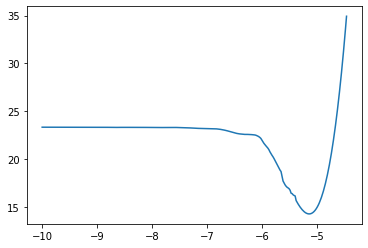

In [ ]:
from scipy.signal import savgol_filter

training_loss_smooth = savgol_filter(np.array(losses), 101, 3)
plt.plot(log_lrs,training_loss_smooth)

In [ ]:
# Learning rate can be finicky, close to leftmost minima
LR_10 = log_lrs[np.argmin(np.diff(training_loss_smooth))+1]
#LR_10 = -5 #-4.921666666666658
#LR_10 = -2
LR = 10**LR_10
print('Learning Rate from Minima: ', LR)
print('log_10(LR): ', LR_10)
#LR = 10**(np.log10(-5.5))

Learning Rate from Minima:  2.3085183622427994e-06
log_10(LR):  -5.63666666666666


In [ ]:
local_model = SubNet()
fed_mod = QlsdPP(local_model, 
                 data.partition_sizes, 
                 lr = LR,
                 s = 2**p,
                 l = l,
                 preconditioner = Adam, 
                 prior = Gaussian(0,0.1), device = device,
                 MALA = True)

In [ ]:
training_loss = train(fed_mod, data, batch_size, l, 4000, p = 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 1 Loss: 23.145533
Epoch 101 Loss: 14.054606
Epoch 201 Loss: 8.051249
Epoch 301 Loss: 5.907751
Epoch 401 Loss: 5.197047
Epoch 501 Loss: 4.733196
Epoch 601 Loss: 4.530804
Epoch 701 Loss: 4.363981
Epoch 801 Loss: 4.263237
Epoch 901 Loss: 4.174806
Epoch 1001 Loss: 4.126699
Epoch 1101 Loss: 4.041432
Epoch 1201 Loss: 4.026085
Epoch 1301 Loss: 4.008116
Epoch 1401 Loss: 3.971715
Epoch 1501 Loss: 3.938886
Epoch 1601 Loss: 3.948369
Epoch 1701 Loss: 3.909026
Epoch 1801 Loss: 3.933086
Epoch 1901 Loss: 3.897209
Epoch 2001 Loss: 3.860873
Epoch 2101 Loss: 3.889560
Epoch 2201 Loss: 3.893169
Epoch 2301 Loss: 3.887274
Epoch 2401 Loss: 3.860960
Epoch 2501 Loss: 3.817187
Epoch 2601 Loss: 3.847632
Epoch 2701 Loss: 3.833492
Epoch 2801 Loss: 3.870532
Epoch 2901 Loss: 3.848746
Epoch 3001 Loss: 3.834824
Epoch 3101 Loss: 3.811452
Epoch 3201 Loss: 3.814698
Epoch 3301 Loss: 3.816237
Epoch 3401 Loss: 3.838049
Epoch 3501 Loss: 3.813815
Epoch 3601 Loss: 3.842110
Epoch 3701 Loss: 3.833281
Epoch 3801 Loss: 3.841

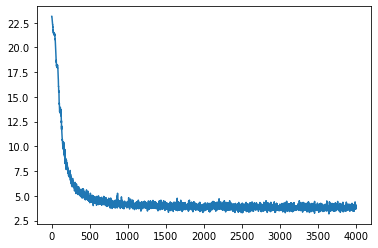

In [ ]:
plt.plot(training_loss)

In [ ]:
train_losses, train_accuracies, train_overall_accuracy, \
raw_out, raw_labels = Test(fed_mod, data, device)

In [ ]:
MNIST_test = torchvision.datasets.MNIST(root = ".",
                                        train = False,
                                        download = True)

data_test = CycleSplitData(MNIST_test,10, transform = lambda x: x/255.)

FMNIST_test = torchvision.datasets.FashionMNIST(root = '.',
                                                train = False,
                                                download = True)

data_test_oos = CycleSplitData(FMNIST_test, 10, transform = lambda x: x/255.)

In [ ]:
test_losses, test_accuracies, test_overall_accuracy\
,raw_test_out, raw_test_labels = Test(fed_mod, data_test, device)

In [ ]:
print(test_accuracies)

[tensor(0.9037, device='cuda:0'), tensor(0.8725, device='cuda:0'), tensor(0.8881, device='cuda:0'), tensor(0.8896, device='cuda:0'), tensor(0.8822, device='cuda:0'), tensor(0.9218, device='cuda:0'), tensor(0.9264, device='cuda:0'), tensor(0.9448, device='cuda:0'), tensor(0.9634, device='cuda:0'), tensor(0.9147, device='cuda:0')]


In [ ]:
# Overall test accuracy is comparable to similar model in non-federated context
print(test_overall_accuracy)

tensor(0.9111)


In [ ]:
print(sum(test_losses)/len(test_losses))

0.3685747891664505


## Extracting model averaged weights

In [ ]:
def post_mean(saved_weights):
  saved_weights = fed_mod.saved_weights
  post_mean = dict.fromkeys(saved_weights[0], 0)
  for weight in saved_weights:
    for layername in weight:
      post_mean[layername] += weight[layername]/len(saved_weights)
  return post_mean

In [ ]:
fed_mod.saved_weights

[{'layer1.bias': tensor([-0.0820, -0.0570,  0.1179,  0.0444,  0.2138, -0.1720,  0.0856,  0.2911,
           0.2149,  0.0380]),
  'layer1.weight': tensor([[ 0.0555,  0.0534, -0.0414,  ...,  0.0126,  0.0290,  0.0136],
          [ 0.0172, -0.0057,  0.0037,  ...,  0.0145, -0.0006,  0.0118],
          [ 0.0093, -0.0184,  0.0078,  ..., -0.0155, -0.0177, -0.0210],
          ...,
          [ 0.0378,  0.0229, -0.0140,  ..., -0.0345,  0.0228, -0.0035],
          [ 0.0224,  0.0081, -0.0128,  ..., -0.0413,  0.0316, -0.0062],
          [ 0.0450, -0.0067, -0.0194,  ..., -0.0205, -0.0014,  0.0259]]),
  'layer2.bias': tensor([-0.0913,  0.0953, -0.0465, -0.0119,  0.0543,  0.1901, -0.0078,  0.0172,
          -0.1960,  0.0874]),
  'layer2.weight': tensor([[ 0.6122,  0.0827, -0.2945, -0.4838,  0.5611, -0.0881, -0.5872,  0.1545,
           -0.2957, -0.1830],
          [-0.6090,  0.0840,  0.7692,  0.6660, -0.1005, -0.2792, -0.3290, -0.2714,
            0.2713, -0.1585],
          [ 0.4402,  0.1224, -0.1037,

In [ ]:
post_mean_dict = post_mean(fed_mod.saved_weights)

In [ ]:
torch.save(fed_mod.central_model['model'], './model_no_processing')

In [ ]:
fed_mod.central_model['model'].load_state_dict(post_mean_dict)

<All keys matched successfully>

In [ ]:
test_losses, test_accuracies, test_overall_accuracy\
, raw_test_output, raw_test_labels = Test(fed_mod, data_test, device)
print(test_overall_accuracy)

tensor(0.9119)


In [ ]:
np.mean(test_losses)

0.3672176763415337

# Calibration

In [ ]:
def plot_reliability(outputs, targets, m_bins):
  boundaries = [i*1/m_bins for i in range(1,1+m_bins)]
  accuracy = [0 for e in range(m_bins)]
  conf = [0 for e in range(m_bins)]
  totals = [0 for e in range(m_bins)]

  
  y, y_ind = F.softmax(outputs, dim = 1).max(dim = 1)

  correct = 1.0*(y_ind == targets)
  for i, y_i in enumerate(y):
    for j, edge in enumerate(boundaries):
      if y[i] <= edge:
        totals[j] += 1
        accuracy[j] += correct[i].item()
        conf[j] += y_i.item()
        break

  for i in range(len(totals)):
    if totals[i] != 0:
      accuracy[i] /= totals[i]
      conf[i] /= totals[i]

  
  fig = plt.figure()
  ax = fig.add_axes([0, 0, 1, 1])
  edges = [1/m_bins*i for i in range(m_bins)]
  accuracy = np.array(accuracy)
  conf = np.array(conf)

  diff = conf - accuracy
  base = accuracy

  ax.bar(edges, base, align = 'edge',
         width = 1/m_bins, alpha = 1, color = '#2c6fbb', edgecolor = 'black',
         linewidth = 0.1, label = "outputs")
  
  ax.bar(edges, diff, bottom = base, align = 'edge', width = 1/m_bins, color = "red",
         edgecolor= "red", alpha = .5, linewidth = 1, hatch = "/", label = "gap")
  
  ax.plot([0,1],[0, 1], "--", alpha = 0.6, linewidth = 3, c = "black")

  ax.legend()

  ECE = 1.0/sum(totals)*sum(totals[i]*abs(accuracy[i]-conf[i])\
                                  for i in range(m_bins))
  
  ax.set_title('Reliability Diagram with ECE {:.3f}'.format(ECE))
  plt.plot()

  return accuracy, conf, totals, ECE

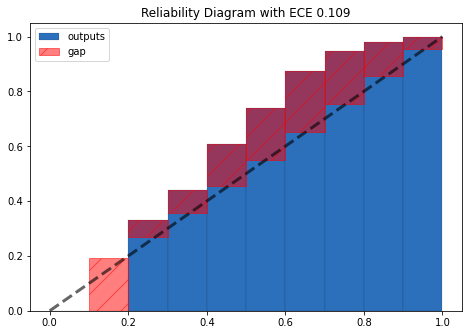

In [ ]:
m_bins = len(MNIST.classes)
acc, conf, total, ECE = plot_reliability(raw_test_output, raw_test_labels, m_bins)

# Out of Sample Test

In [ ]:
test_losses_oos, test_accuracies_oos, test_overall_accuracy_oos\
, raw_test_output_oos, raw_test_labels_oos = Test(fed_mod, data_test_oos, device)
print(test_overall_accuracy_oos)

tensor(0.0965)


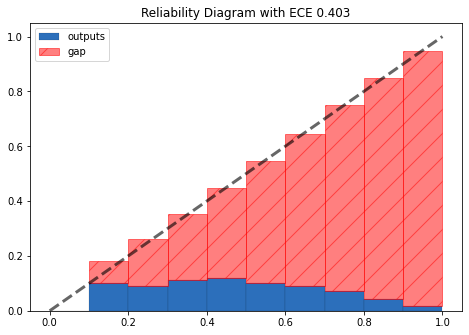

In [ ]:
acc, conf, total, ECE = plot_reliability(raw_test_output_oos, raw_test_labels_oos, m_bins)